In [35]:
# word embedding for korean
import collections
import string
import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
matplotlib.rc('font',family='NanumGothic')

print ("package loaded")

package loaded


In [2]:
# Hangul Tokenizer (Konlpy - Twitter)
from konlpy.tag import Twitter
twitter = Twitter()

exclude_pos = ['Eomi','Josa','Number','KoreanParticle','Punctuation']

def pprint(list_text):
    pstr = "[" + ','.join(list_text) + "]"
    print pstr

def tokenizer(phrase):    
    return [unicode(tup[0]) for tup in twitter.pos(phrase, norm=True, stem=False)  if (tup[1] not in exclude_pos)]

pprint(tokenizer(u'이것은 한국어를 처리하기 위한 도구 입니다. 정말 잘 만들었습니다.'))

[이,것,한국어,처리,하기,위한,도구,입니,정말,잘,만들었]


In [3]:
# Load corpus
f_corp= open('testtxt/namuwiki.txt.clean')
content = f_corp.read()

exclude = set(string.punctuation)
content_punc_removed = ''.join(ch for ch in content if ch not in exclude)
sentences = content_punc_removed.split('\n')
sentences = map(lambda stnc : unicode(stnc.decode('utf-8')), sentences)

print ("number of origin lines : " + str(len(sentences)))

number of origin lines : 2001


In [4]:
# list of all words
words = ""
for stnc in sentences:
    tokens = tokenizer(stnc)
    words += " "+" ".join(tokens)
words = words.split()

print ("size of words : " +  str(len(words)))

size of words : 56815


In [5]:
pprint(words[:100])

[초반,이말년,수필,이름,걸,맞게,이말년,의,생활,담,예정,이었,점점,주변,인물,ex,만화,가족,직원,들,비타민,만화가,이기호,작가,후렛샤,작가,기안,NUMBER,작가,등,로,범위,넓혀,지,있다,주변,얼굴,사람,같지,않게,그려,놔,원성,자자,하,딸도,못,생기,그린,걸,봐선,그냥,그림,못,그리는,것,NUMBER,화,프롤로그,소문,있다,에피소드,NUMBER,화,URL,피키툰,굳이,연재,하는,이유,NUMBER,화,URL,망치,이말년,치밀,계획,NUMBER,화,URL,탄,이말년,소환,누가,좀,도와줘,NUMBER,화,URL,누구,간절,히,바라는,이,것,NUMBER,화,URL,떠오르는,악몽]


In [6]:
# count words
voca_size = 9000
count = [('UNK', -1)]
count.extend(collections.Counter(words).most_common(voca_size-1))
print ("count list size : " + str(len(count)))
print ("Top 5 words are below")
for tup in count[:5]:
    print(tup[0] + " : " + str(tup[1]))

count list size : 9000
Top 5 words are below
UNK : -1
NUMBER : 4713
옵션 : 582
이 : 535
들 : 437


In [7]:
# make dictionary
rdic = [tup[0] for tup in count]
dic = {w : i for i, w in enumerate(rdic)}
dic_size = len(dic)
print ('dictionary size : ' + str(dic_size))

dictionary size : 9000


In [8]:
pprint (rdic[:100])

[UNK,NUMBER,옵션,이,들,년,만,것,적,수,했,달러,URL,일,월,때문,한,된,의,있다,화,그,있,위,되었,개봉,주차,그리고,가,할,있는,하는,때,를,중,경우,주,시,되,력,로,액,매출,억,증가,전주,속도,로드,아웃,분류,하지만,못,좋,가장,후,힐,전,밤,등,북미,아니,자신,되는,와,한국,더,caff,더티,누적,해외,나,다,말,에서,작가,개관,벌었,시간,총,정도,자체,었,번,사람,사실,없는,안,범위,는,a,스킬,이후,도민준,거의,데,같은,동안,차지,영화,였]


In [43]:
# Word embedding options
skip_window = 3
num_skip = 1
embedding_size = 400
batch_size = 1000
learning_rate = 0.01
negative_sample = 100
training_epoch = 100000
display_step = 2000

# Test embedding options
test_size = 30
test_K = 10

In [11]:
# make skip grammer pairs
skip_gram_data = []
for sentence in sentences:
    words = tokenizer(sentence)
    for i, word in enumerate(words):
        if word not in rdic:
            word = 'UNK'
        for w in range(-skip_window, skip_window+1, num_skip):
            if i + w >= 0 and i + w < len(words) and w != 0 :
                if words[i+w] in rdic:
                    r_word = words[i+w]
                else:
                    r_word = 'UNK'
                skip_gram_data.append([dic[word] , dic[r_word]])

print ('skip gram pairs : ' + str(skip_gram_data [:30]))

skip gram pairs : [[1314, 415], [1314, 4113], [1314, 212], [415, 1314], [415, 4113], [415, 212], [415, 307], [4113, 1314], [4113, 415], [4113, 212], [4113, 307], [4113, 4877], [212, 1314], [212, 415], [212, 4113], [212, 307], [212, 4877], [212, 415], [307, 415], [307, 4113], [307, 212], [307, 4877], [307, 415], [307, 18], [4877, 4113], [4877, 212], [4877, 307], [4877, 415], [4877, 18], [4877, 577]]


In [12]:
def random_batch(skip_gram_pairs, batch_size):
    x = []
    y = []
    r = np.random.choice(range(len(skip_gram_pairs)), batch_size, replace=False)
    for idx in r :
        x.append(skip_gram_pairs[idx][0])
        y.append([skip_gram_pairs[idx][1]])
    return x, y

print ("random batch test : " + str(random_batch(skip_gram_data, 5)))

random batch test : ([1928, 1, 427, 11, 1], [[1589], [1], [21], [660], [154]])


In [13]:
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeddings = tf.Variable(tf.random_uniform([dic_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.random_uniform([dic_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([dic_size]))

# Compute the average NCE loss for the batch.
cost = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels, negative_sample, dic_size))

# Use the adam optimizer
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.initialize_all_variables()

# Observe test words with cosine similarity with other words
test_words = tf.placeholder(tf.int32, shape=[test_size])
normalized_embeddings = embeddings / tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
test_embeddings = tf.nn.embedding_lookup(normalized_embeddings, test_words)
cosim = tf.matmul(test_embeddings, normalized_embeddings, transpose_b=True)

print ("Graph build")

Graph build


In [14]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epoch):
    batch_inputs, batch_labels = random_batch(skip_gram_data, batch_size)
    cost_val, _ = sess.run([cost, optm],feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
    if epoch % display_step == 0:
        print ("epoch: %05d/%05d  ,  cost: %.6f" % (epoch, training_epoch, cost_val))

real_embeddings = sess.run(embeddings)
circle_embeddings = sess.run(normalized_embeddings)
print ("Training complete")

epoch: 000/100000  ,  cost: 461.934418
epoch: 2000/100000  ,  cost: 4.300825
epoch: 4000/100000  ,  cost: 4.447318
epoch: 6000/100000  ,  cost: 4.225175
epoch: 8000/100000  ,  cost: 4.439972
epoch: 10000/100000  ,  cost: 4.675635
epoch: 12000/100000  ,  cost: 5.208479
epoch: 14000/100000  ,  cost: 4.899956
epoch: 16000/100000  ,  cost: 4.339689
epoch: 18000/100000  ,  cost: 4.428215
epoch: 20000/100000  ,  cost: 4.477117
epoch: 22000/100000  ,  cost: 4.156227
epoch: 24000/100000  ,  cost: 4.352493
epoch: 26000/100000  ,  cost: 4.206718
epoch: 28000/100000  ,  cost: 4.093830
epoch: 30000/100000  ,  cost: 4.107003
epoch: 32000/100000  ,  cost: 4.236155
epoch: 34000/100000  ,  cost: 4.197736
epoch: 36000/100000  ,  cost: 4.181228
epoch: 38000/100000  ,  cost: 4.288094
epoch: 40000/100000  ,  cost: 4.329542
epoch: 42000/100000  ,  cost: 3.810983
epoch: 44000/100000  ,  cost: 4.083332
epoch: 46000/100000  ,  cost: 3.932430
epoch: 48000/100000  ,  cost: 4.130329
epoch: 50000/100000  ,  cost:

In [15]:
print ("real_embedding shape : " + str(real_embeddings.shape))
print ("circle_embedding shape : " + str(circle_embeddings.shape))

real_embedding shape : (9000, 400)
circle_embedding shape : (9000, 400)


In [51]:
test_inputs, test_labels = random_batch(skip_gram_data, test_size)
test_words_similarity = sess.run(cosim, feed_dict={test_words:test_inputs})
for i, widx in enumerate(test_inputs):
    word = rdic[widx]
    nearest = (-test_words_similarity[i,:]).argsort()[1:test_K+1]
    nearest_words = [ rdic[wndx] for wndx in nearest ]
    print ("%s ~= %s" % (word, ','.join(nearest_words)))

했 ~= 액,누적,북미,달러,벌어,개봉,것,위,전주,그리고
강하고 ~= 중,무기,한국,과,했,강화,되,강한,공격,리치
주차 ~= 해외,누적,액,개봉,북미,주말,전주,개관,달러,만
이 ~= 그,것,옵션,중,때문,한,강화,되,적,달리
많이 ~= 것,옵션,해외,력,가장,있는,액,누적,많은,수
후 ~= 되,URL,력,시,것,최대,적,옵션,때문,하는
밤 ~= 더티,력,광역,수,소리,강화,증가,옵션,범위,속도
증가 ~= 속도,감소,강화,범위,최대,시켜,되는,시,수치,밤
받고 ~= 것,적,줄,있다,정도,할,을,수,매우,장판
터지니 ~= 절친,일하다,실패한,MBC,그만두고,자키,방지,육상,미술,서기
UNK ~= 되,URL,것,되는,들,을,수,다,강화,달리
받았 ~= 것,아웃,로드,이후,적,있,로,출시,한,대
억 ~= 달러,해외,벌어,액,누적,만,벌었,전주,총,북미
시 ~= 속도,증가,범위,HP,최대,되는,URL,공격,달리,강화
NUMBER ~= 되,옵션,주말,URL,로드,북미,력,주,만,많은
봤 ~= 것,과,있,내,적,지구,액,등,도민준,하며
근육 ~= 함대,이세,거의,컬렉션,과,의,되,바보,것,있었
않아 ~= 강화,매우,옵션,범위,것,스파크,수,아웃,밤,상당히
Rock ~= 막부,br,카,김포,왕자,s,님,스케,E,대
오후 ~= 같은,일,된,월,시간,KBS,점착,방송,북미,적
NUMBER ~= 되,옵션,주말,URL,로드,북미,력,주,만,많은
일 ~= 월,액,할,URL,해외,시간,나,후,개관,개봉
안되는 ~= 수,증가,범위,속도,있,최대,공격,지속,강화,밤
세계 ~= 액,해외,벌었,달러,억,벌어,누적,전주,만,전
제안 ~= DcDcDc,견착,해준,였,다시,살짝,특히,할,죽었,시즌
빠지 ~= Rock,말,때문,되,보고,지구,관계,Nader,아카기,같은
다르 ~= 시선,있다,과,학파,같은,그,있는,들,적,입
드론 ~= 디덴,하지만,플로,자체,매우,기동,Dirty,듀엣,에이미,DcDcDc
하락 ~= 주말,달러,상승,벌어,억,전주,박스오피스,만,개관,위
일 ~= 월,액,할,URL,

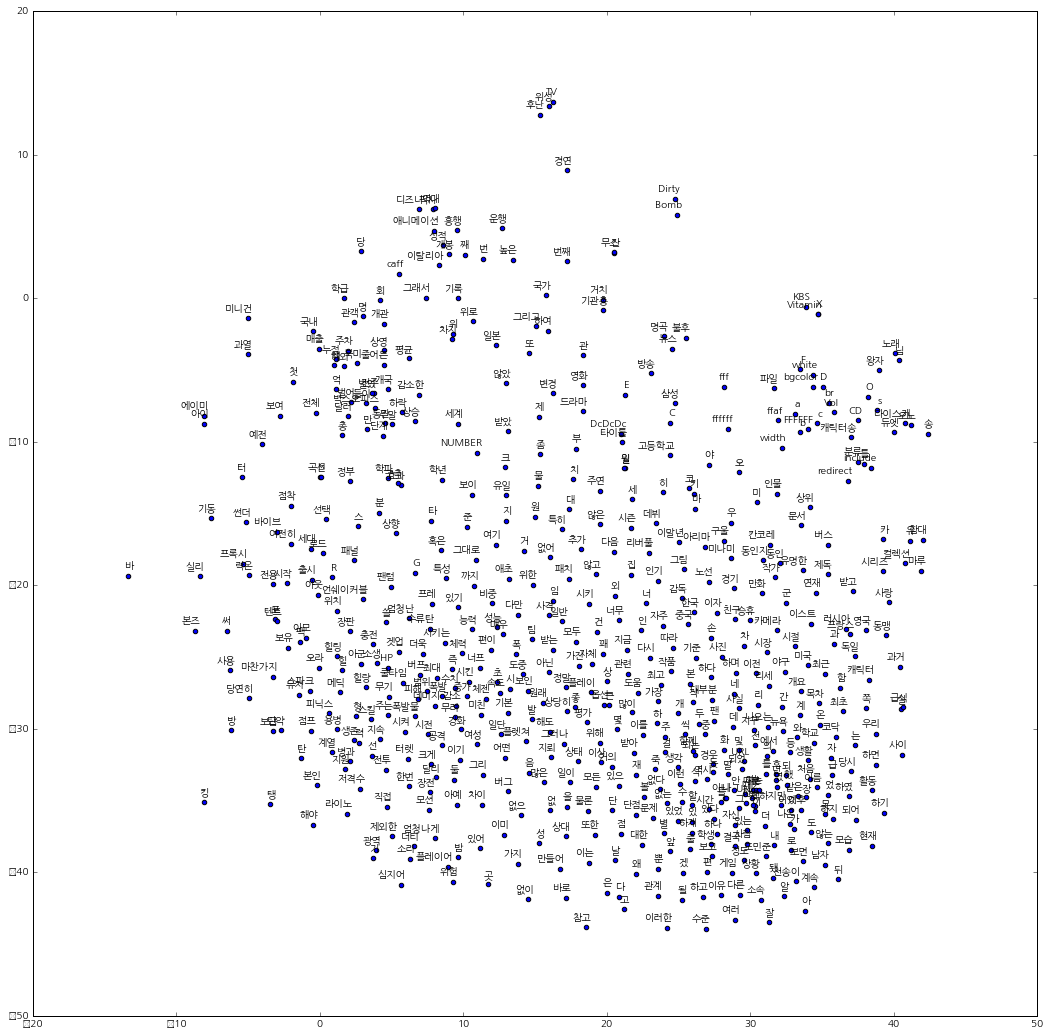

In [89]:
from sklearn.manifold import TSNE

# Convert to low(2) dimension emdedding
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000)
ps,pe = (0, 600)
low_dimension_embeddings = tsne.fit_transform(real_embeddings[ps:pe,:])
labels = [rdic[i] for i in range(ps,pe)]

# Show plot
plt.figure(figsize=(18,18))
for i, label in enumerate(labels):
    x, y = low_dimension_embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate('%s' % label, xy=(x, y), xytext=(5, 5), textcoords='offset points', ha='right', va='bottom')
plt.show()